In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import pandas as pd
# import scipy as needed

In [3]:
#Import Sun Roof and Election data

solar_raw = pd.read_csv("./project-sunroof-county.csv")
county_elec_raw = pd.read_csv("./county_2018_elections.csv", encoding = "ISO-8859-1")

In [4]:
#For zipcodes that have no installations, energy outputs like yearly_sunlight_kwh_median are null so set to 0
solar_data = solar_raw.fillna(0)
#solar_data.isnull().sum() #Should all be 0

In [5]:
# We're only looking at areas in California and Texas, so discard the rest of the data
solar_ca_tx = solar_data[(solar_data['state_name'] == 'California') | (solar_data['state_name'] == 'Texas')].reset_index()
solar_ca_tx = solar_ca_tx.sort_values('region_name')
solar_ca_tx['region_name'] = solar_ca_tx['region_name'].apply(lambda x: x[0:-7])
solar_ca_tx.head()

,index,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,7,Alameda,California,37.905009,37.456808,-121.486198,-122.339559,37.704488,-122.086472,1229.95,...,7.842750e+08,2.233938e+09,1.511940e+09,1.912288e+09,4.657260e+09,17568.447668,1.109970e+10,"[[0,41995],[5,99875],[10,87007],[15,66149],[20...",3.025442e+06,14127.0
1,24,Angelina,Texas,31.500373,31.069414,-94.266768,-94.958244,31.321144,-94.716887,1074.40,...,3.846356e+07,8.050091e+07,5.880459e+07,6.831148e+07,2.622145e+08,14796.402393,5.082951e+08,"[[0,2402],[5,3521],[10,2771],[15,1899],[20,110...",2.755661e+05,15.0
2,28,Aransas,Texas,28.318048,27.839152,-96.797801,-97.238939,28.035275,-97.067863,1117.75,...,3.984289e+07,6.101898e+07,4.142638e+07,5.073400e+07,9.641537e+07,17119.256494,2.894376e+08,"[[0,1689],[5,2738],[10,2307],[15,1889],[20,126...",1.400916e+05,16.0
3,30,Archer,Texas,33.835423,33.396290,-98.422385,-98.952502,33.706751,-98.625161,1187.45,...,1.568274e+06,6.059047e+06,2.914378e+06,4.815493e+06,3.524540e+06,22790.674805,1.888173e+07,"[[0,56],[5,119],[10,154],[15,181],[20,136],[25...",9.181930e+03,1.0
4,35,Atascosa,Texas,29.244721,28.700725,-98.177500,-98.804700,29.046634,-98.577237,1102.45,...,1.804525e+07,2.929326e+07,1.874889e+07,2.430173e+07,7.178925e+07,17409.466229,1.621784e+08,"[[0,755],[5,1194],[10,1176],[15,934],[20,564],...",7.886515e+04,3.0


Using the table from above, we can see that the zipcode with the highest number of PV installs is 95762, which is El Dorado Hills, a suburban area East of Sacramento. The second most is Livermore, just East over the hills from Oakland.

In [6]:
solar_to_merge = solar_ca_tx[['region_name', 'state_name', 'lat_avg', 'lng_avg', 'existing_installs_count', 'number_of_panels_total']].rename(columns={'region_name':'county', 'state_name':'state', 'existing_installs_count':'curr_installs', 'number_of_panels_total':'total_installs'})
solar_to_merge['install_prop'] = solar_to_merge['curr_installs'] / solar_to_merge['total_installs']
solar_to_merge = solar_to_merge.sort_values('county')[['county', 'state', 'lat_avg', 'lng_avg', 'install_prop']]
solar_to_merge

,county,state,lat_avg,lng_avg,install_prop
0,Alameda,California,37.704488,-122.086472,0.000457
1,Angelina,Texas,31.321144,-94.716887,0.000009
2,Aransas,Texas,28.035275,-97.067863,0.000019
3,Archer,Texas,33.706751,-98.625161,0.000019
4,Atascosa,Texas,29.046634,-98.577237,0.000006
...,...,...,...,...,...
105,Wichita,Texas,33.920948,-98.555683,0.000006
106,Williamson,Texas,30.575513,-97.706460,0.000042
107,Wise,Texas,33.143811,-97.630130,0.000000
108,Yolo,California,38.606905,-121.731508,0.000702


In [7]:
voting_data = county_elec_raw[((county_elec_raw['state']=='Texas') | (county_elec_raw['state']=='California')) & (county_elec_raw['office']=='Governor')]
voting_data = voting_data[['county', 'party', 'candidatevotes', 'totalvotes', 'state']]

by_dem = voting_data[voting_data['party']=='democrat'].rename(columns={'candidatevotes':'d_votes'})
by_rep = voting_data[voting_data['party']=='republican'].rename(columns={'candidatevotes':'r_votes', 'state':'drop'})
together = pd.merge(by_dem, by_rep, on=['county'], how='inner')[['county', 'state', 'd_votes', 'r_votes']]
together['d_prop'] = together['d_votes'] / (together['d_votes'] + together['r_votes'])
together['r_prop'] = together['r_votes'] / (together['d_votes'] + together['r_votes'])


final = together[['county', 'state', 'd_prop', 'r_prop', 'd_votes', 'r_votes']]
votes_to_merge = final.sort_values('county')
votes_to_merge

,county,state,d_prop,r_prop,d_votes,r_votes
0,Alameda,California,0.805520,0.194480,462558.0,111677.0
1,Alpine,California,0.627642,0.372358,386.0,229.0
2,Amador,California,0.354516,0.645484,6237.0,11356.0
65,Anderson,Texas,0.196438,0.803562,2868.0,11732.0
66,Andrews,Texas,0.168094,0.831906,687.0,3400.0
...,...,...,...,...,...,...
63,Yolo,California,0.678193,0.321807,49759.0,23611.0
314,Young,Texas,0.115147,0.884853,726.0,5579.0
64,Yuba,California,0.359606,0.640394,6903.0,12293.0
315,Zapata,Texas,0.600093,0.399907,1292.0,861.0


In [8]:
merged = pd.merge(solar_to_merge, votes_to_merge, how='left', on='county')
merged

,county,state_x,lat_avg,lng_avg,install_prop,state_y,d_prop,r_prop,d_votes,r_votes
0,Alameda,California,37.704488,-122.086472,0.000457,California,0.805520,0.194480,462558.0,111677.0
1,Angelina,Texas,31.321144,-94.716887,0.000009,Texas,0.245375,0.754625,6406.0,19701.0
2,Aransas,Texas,28.035275,-97.067863,0.000019,Texas,0.202547,0.797453,1797.0,7075.0
3,Archer,Texas,33.706751,-98.625161,0.000019,Texas,0.090173,0.909827,323.0,3259.0
4,Atascosa,Texas,29.046634,-98.577237,0.000006,Texas,0.304178,0.695822,3655.0,8361.0
...,...,...,...,...,...,...,...,...,...,...
111,Wichita,Texas,33.920948,-98.555683,0.000006,Texas,0.257665,0.742335,8614.0,24817.0
112,Williamson,Texas,30.575513,-97.706460,0.000042,Texas,0.445079,0.554921,90002.0,112214.0
113,Wise,Texas,33.143811,-97.630130,0.000000,Texas,0.139545,0.860455,3184.0,19633.0
114,Yolo,California,38.606905,-121.731508,0.000702,California,0.678193,0.321807,49759.0,23611.0


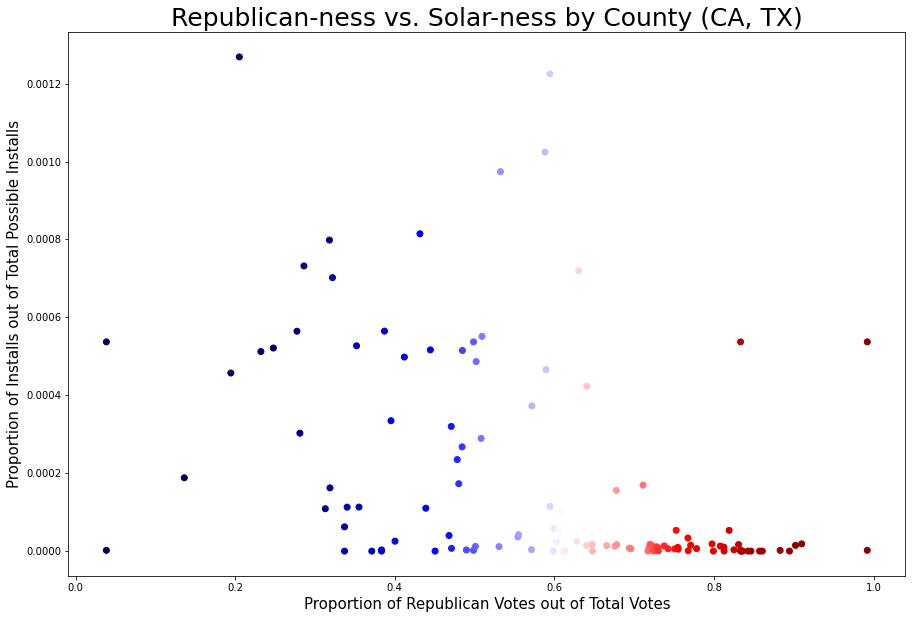

In [9]:
most_republican = merged.sort_values('r_prop')

plt.figure(figsize=(15, 10))
plt.scatter('r_prop', 'install_prop', data=most_republican, c=np.arange(0, 116), cmap='seismic')
plt.xlabel('Proportion of Republican Votes out of Total Votes', size=15)
plt.ylabel('Proportion of Installs out of Total Possible Installs', size=15)
plt.title('Republican-ness vs. Solar-ness by County (CA, TX)', size=25)
plt.show()

In [10]:
merged.to_csv(r'./merged.csv')

In [11]:
included = merged['county']
not_included = votes_to_merge[~votes_to_merge['county'].isin(included)]
not_included.to_csv(r'./not_included.csv')

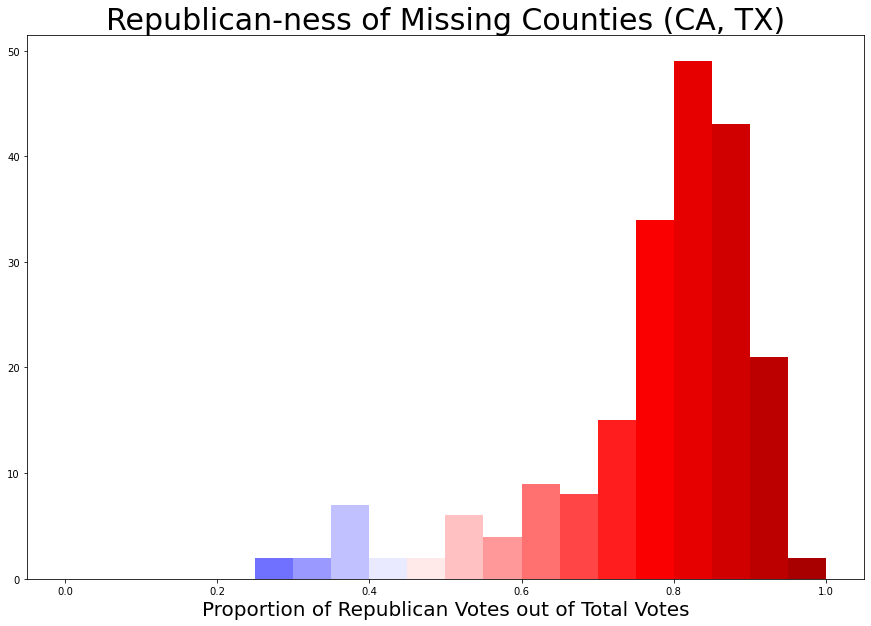

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
N, bins, patches = axs.hist('r_prop', data=not_included, bins=np.arange(0, 1.05, .05))

norm = colors.Normalize(0, 1.25)
for thisfrac, thispatch in zip(np.arange(.2, 1.25, .05), patches):
    color = plt.cm.seismic(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Proportion of Republican Votes out of Total Votes', size=20)
plt.title("Republican-ness of Missing Counties (CA, TX)", size=30)
plt.show()

## Todo:

    Look into percentage of non-voters (census data)
    Look into population by county (also census data)
    Make graph in Tableau/Carto
    Look into racial make-up of counties (also also census data)
    Combine findings with Frannie Mae credit score data
    Combine findings with Freddie Mac credit score data
    Look into deep solar data
    Use areal interpolation (tobler library) to make data more granular

/newline

## Areal Interpolation of Project Sunroof Data

In [2]:

solar_data

NameError: name 'county_elec_raw' is not defined